In [6]:
import os
data_dir = './data/experiments'
data_files = [' '] + os.listdir(data_dir)
#if 'message.npy' in os.listdir():
#    os.remove('message.npy')

# Widget styles
default = (data_files[0], ' ')
style = {'description_width': 'initial'}
features_layout = {'width': 'max-content','height':'200px'}

from IPython.display import display, HTML, clear_output, display_html
from itertools import chain,cycle
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, Layout, HBox, VBox
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', 100)
import numpy as np
import time
import re
import sys
import requests
import subprocess
import numpy as np
import sqlite3
from zipfile import ZipFile
import pika
import json
import ast
import threading


# File selection menu
file_dd=widgets.SelectMultiple(options=data_files,value=default,
    description='File:',style=style,layout=features_layout)
# Analyse button 
run_button = widgets.Button(description = "Cluster",style=style)
run_button.style.button_color = 'lightgreen'
# Metric menues
metrics_layout = {'display':'flex','width': '130px','height':'30px', 'justify_content':'flex-end'}
options = list(np.arange(1,11))
options = [str(o) for o in options]
metrics_optimize = {'min_max_tpc': ('min', 1), 'wcss': ('min', 1), 'bcss': ('max', 1), 'ch_index': ('max', 1),\
'db_index':('min', 1), 'silhouette':('max', 1), 'words_pairs': ('max', 1)}
metrics = list(metrics_optimize.keys())
metrics_menues = {}
for metric in metrics:
    menue=widgets.Dropdown(options=options,value='1',description=metric, layout=metrics_layout)
    metrics_menues[metric]=menue
# Granularity slider
granularity = widgets.IntSlider(value=100, min=2, max=1000, step=1, description='Number of Clusters',\
                                     orientation='horizontal',readout=True, readout_format='d',\
                                     style = {'description_width': 'initial'}, layout=Layout(width='400px'))
apply_granularity = widgets.ToggleButton(value=False, description='Select granularity level?',
    disabled=False, button_style='info', tooltip='Description',
    icon='check', layout=Layout(width='200px'))
# Minimal cluster size
min_cluster_menue=widgets.Dropdown(options=['0']+ options,value='4',\
                       description='Minimum number of tasks in cluster',\
                                   style = {'description_width': 'initial'},\
                                   layout=Layout(width='300px'))

# Service    
url = 'http://127.0.0.01:6002/cluster_analysis/api/v0.1/clustering'
out = widgets.Output() 
metrics_optimize = {'min_max_tpc': ('min', 1), 'wcss': ('min', 1), 'bcss': ('max', 1), 'ch_index': ('max', 1),\
'db_index':('min', 1), 'silhouette':('max', 1), 'words_pairs': ('max', 1)}
conn = sqlite3.connect('./results/CAdb')
c = conn.cursor()

def print_results(b):
    pass
            
def run_service(b):
    
    file_checkpoints = True
    ## Submitted data files
    files = file_dd.value
    print('files:', files)
    file_types = list(set([t.split('.')[1] for t in files]))
    print('file types:', file_types)
    #Checkpoint: Files submitted
    if files[0][0] == ' ':
        print('No file selected')
        file_checkpoints = False
    #Checkpoint: Zip files
    elif 'zip' in file_types:
        #Checkpoint: One among few files zipped 
        if len(file_types)>1: 
            print('The submitted files include a zip file')
            file_checkpoints = False
        else: 
            data_path = os.path.join(data_dir, files[0])
            files = {'file': open(data_path, 'rb')} 
    #Zip data files 
    else:
        file_paths = []
        for file in files:
            file_paths.append(os.path.join(data_dir, file))
        print('file_paths:', file_paths)
        with ZipFile('zipped_files.zip','w') as zip:
            # writing each file one by one
            for file_path in file_paths:
                zip.write(file_path)
        files = {'file': open('zipped_files.zip', 'rb')}
        os.remove('zipped_files.zip')
    
    if file_checkpoints:
        ## Experiment configuration
        config = {}
        # Experiment id
        experiment_ids = pd.read_sql_query("SELECT experiment_id from experiments", conn).astype(int)
        if len(experiment_ids) == 0: experiment_id = 1
        else: experiment_id = int(max(experiment_ids.values)[0]) + 1

        print('experiment_id:', experiment_id)
        config['experiment_id'] = experiment_id

        min_cluster_size = min_cluster_menue.value[0]
        print('min_cluster_size:', min_cluster_size)
        config['min_cluster_size'] = min_cluster_size

        # Metric weights
        for metric, menue in metrics_menues.items():
            config[metric] = menue.value[0]
        if apply_granularity.value:
            config['num_clusters'] = granularity.value

        response = requests.post(url, files=files, data=config)
        print(response.text)
        if response.text == 'Activity names are being clustered':
            run_consumer()
            clusters = np.load('message.npy', allow_pickle=True)[()]
            print('Best performing run id=', list(clusters.keys())[0])
            experiment_ids = pd.read_sql_query("SELECT experiment_id FROM experiments", conn).astype(int)
            current_id = int(max(experiment_ids.values)[0])
            run_cols = ['project_name', 'customer', 'run_start', 'run_end', 'duration', 'tasks_count']
            experiment_df = pd.read_sql_query("SELECT * FROM experiments \
            WHERE experiment_id={cid}".format(cid=current_id), conn).drop(run_cols, axis=1)
            display(HTML('<h1 style="color:magenta">Run Scores </h1>'))
            display(experiment_df)
            print('Clusters ready for drill down analysis')

#EXCHANGE, QUEUE_NAME = 'kc.ca.exchange', 'kc.ca.queue'
EXCHANGE, QUEUE_NAME = 'kc.ca_research.exchange', 'kc.ca_research.queue'

class ThreadedConsumer(threading.Thread):
  def __init__(self):
    threading.Thread.__init__(self)
    credentials = pika.PlainCredentials('rnd', 'Rnd@2143')
    parameters = pika.ConnectionParameters('172.31.34.107', 5672, '/', credentials)
    connection = pika.BlockingConnection(parameters)
    self.channel = connection.channel()
    self.channel.queue_declare(queue=QUEUE_NAME, auto_delete=False)
    self.channel.exchange_declare(exchange=EXCHANGE, durable=True, exchange_type='direct')
    self.channel.basic_qos(prefetch_count=10)
    self.channel.basic_consume(QUEUE_NAME, on_message_callback=self.callback)
    threading.Thread(target=self.channel.basic_consume(QUEUE_NAME, on_message_callback=self.callback))

  def callback(self, channel, method, properties, body):
    message = ast.literal_eval(body.decode('utf-8'))
    print('message')
    print(message)
    np.save('message.npy', message)
    
  def run(self):
    self.channel.start_consuming()

def run_consumer():
    td = ThreadedConsumer()
    td.start()
    td.join(0)

In [2]:
# Dashboard
run_button.on_click(run_service)
display(HTML('<h1 style="color:magenta">Cluster Activities</h1>\
              <p style="color:blue">Use to following menus to submit a file for analysis:</p>\
                 <ul>\
                  <li style="color:magenta">File to analyze</li>\
                  <li style="color:magenta">Select granularity level</li>\
                  <li style="color:magenta">Set weights for validation metrics</li>\
                </ul>'))
file_box = VBox(children=[file_dd, run_button])
metrics_box = VBox(children=list(metrics_menues.values()))
config_box = VBox(children=[apply_granularity, granularity, min_cluster_menue])
HBox(children=[file_box, config_box, metrics_box])

In [7]:
def left_align(df):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:right"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        df=left_align(df)
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

    
def print_results(b):
    #clear_output()
    cluster_key = clusters_keys_dd.value[0]
    if cluster_key == ' ':
        print('No key selected')
    else:
        clustering_result = np.load('message.npy', allow_pickle=True)[()]
        clusters = list(clustering_result.values())[0]
        
        # Activities duration values
        cluster_ids = [i[0] for i in clusters[cluster_key]]
        planned_duration_dict = clustering_result['planned_duration_vals']
        planned_duration_dict = {k:v for k,v in planned_duration_dict.items() if k in cluster_ids}
        #print('planned_duration_dict:', planned_duration_dict)
        planned_duration_vals = list(planned_duration_dict.values())
        #print('planned_duration_vals:', planned_duration_vals)
        
        actual_duration_dict = clustering_result['actual_duration_vals']
        actual_duration_dict = {k:v for k,v in actual_duration_dict.items() if k in cluster_ids}
        #print('actual_duration_dict:', actual_duration_dict)
        actual_duration_vals = list(actual_duration_dict.values())
        #print('actual_duration_vals:', actual_duration_vals)
        
        planned_in_actual_dict = {k:v for k,v in planned_duration_dict.items() if k in actual_duration_dict.keys()}
        #print('planned_in_actual_dict:', planned_in_actual_dict)
            
        # Duration ratios and overruns
        duration_ratios, tasks_overrun, tasks_overrun_perc = [], [], []
        for id, task_planned_duration in planned_in_actual_dict.items():
            task_actual_duration = actual_duration_dict[id]
            if task_planned_duration != 0:
                duration_ratios.append(round(task_actual_duration/task_planned_duration,2))
                task_overrun = task_actual_duration-task_planned_duration
                tasks_overrun.append(task_overrun)
                tasks_overrun_perc.append(task_overrun/task_planned_duration)

        ## Cluster Statistics
        display(HTML('<h1 style="color:magenta">Cluster RCF Analysis</h1>'))
        print('Cluster Statistics')
        print('Activities in Cluster:', len(cluster_ids))
        print('Completed Activities in Cluster:', len(actual_duration_vals))
        # Table
        index = ['Planned Duration(Days)', 'Actual Duration(Days)', 'Overrun(Days)', 'Overrun(%)']
        headers = ['MEAN', 'MEDIAN', 'STD']
        def stats_row(arr): return [np.mean(arr), np.median(arr), np.std(arr)]
        table_rows = [stats_row(planned_duration_vals), stats_row(actual_duration_vals),\
                     stats_row(tasks_overrun), stats_row(tasks_overrun_perc)]
        stats_df = pd.DataFrame(table_rows, columns=headers, index=index)
        stats_df = round(stats_df, 2)
        #display(stats_df)                
        
        # Plot Values: RCF for Tasks in Cluster
        # x = percentile,  y = duration_ratios
        duration_ratios.sort()
        sum_ratios = sum(duration_ratios)
        ratios_cumsum = np.cumsum(duration_ratios)
        percentile = 100*(ratios_cumsum/sum_ratios)
        rcf_df = pd.DataFrame(list(zip(percentile, duration_ratios)),\
                              columns = ['Percentile', 'Duration Ratio'])
        
        # Plot Values: Duration Distribution
        duration_type = len(planned_duration_vals) * ['Planned'] + len(actual_duration_vals) *['Actual']
        duration_vals = list(planned_duration_vals)+list(actual_duration_vals)
        duration_df = pd.DataFrame(list(zip(duration_type, duration_vals)), columns=['Duration', 'Days'])
        names = [i[1] for i in clusters[cluster_key]]
        names_df = pd.DataFrame(names, columns=[''])
        
        ## Display
        # Tables
        display_side_by_side(names_df,stats_df, titles=['Tasks in Cluster','Cluster Statistics'])
        
        # Plots
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))#, sharey=True)
        duration_dist = sns.boxplot(ax=axes[0], x="Duration", y="Days", data=duration_df)
        rcf = sns.lineplot(ax=axes[1], x="Percentile", y="Duration Ratio", data=rcf_df)
        axes[0].set_title('Duration Distibution (Tasks in Cluster)')
        axes[1].set_title('RCF For Tasks in Cluster')
        fig.suptitle('Initial Pokemon - 1st Generation') 

Cluster Statistics
Activities in Cluster: 5
Completed Activities in Cluster: 5


Tasks in Cluster 
 
 
 
   
 
 
 
 
 
 0 
 BA14 submission & pile test 
 
 
 1 
 Post Drilling / BD Selection / Load Tests / BD Consent for Pile Cap 
 
 
 2 
 Construct Trials & Test for BD inspection and acknowledgement 
 
 
 3 
 Shaft F - BD inspection on stratum 
 
 
 4 
 Tie In Works to BD Vessel 
 
 
 
 Cluster Statistics 
 
 
 
   
 MEAN 
 MEDIAN 
 STD 
 
 
 
 
 Planned Duration(Days) 
 26.000000 
 22.000000 
 17.990000 
 
 
 Actual Duration(Days) 
 26.400000 
 27.000000 
 17.980000 
 
 
 Overrun(Days) 
 0.500000 
 -1.000000 
 10.040000 
 
 
 Overrun(%) 
 0.080000 
 -0.060000 
 0.390000

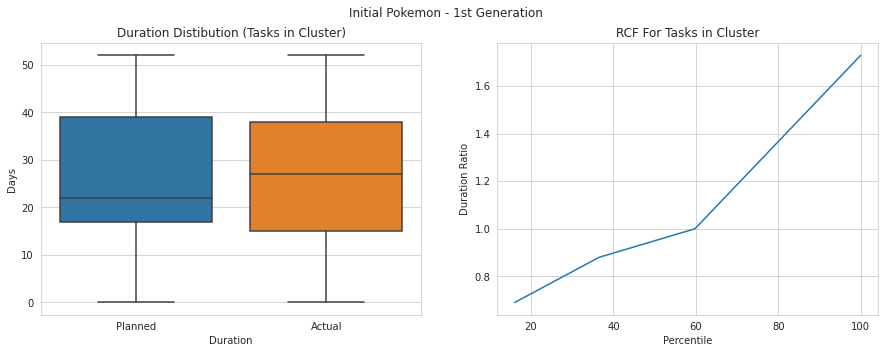

In [8]:
display(HTML('<h1 style="color:magenta">Cluster names for best performing run </h1>'))
clusters_keys = [' ']
if 'message.npy' in os.listdir():
    clusters = np.load('message.npy', allow_pickle=True)[()]
    clusters = list(clusters.values())[0]
    clusters_keys += list(clusters.keys())
default = (clusters_keys[0], ' ')
clusters_keys_dd=widgets.SelectMultiple(options=clusters_keys, value=default,
    description='Select Cluster:',style=style,layout=features_layout)

# Run buttons
button = widgets.Button(description = "Run RCF",style=style)
button.style.button_color = 'lightgreen'

output = widgets.Output()
button.on_click(print_results)
HBox(children=[clusters_keys_dd, button])

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')